In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
from tqdm import tqdm
from p_tqdm import p_map
import librosa
import librosa.display
import random
from skimage.transform import resize
import warnings


In [2]:
warnings.filterwarnings('ignore')

### LISTAGE DES FICHIERS CONTENUS DANS LE DATASET

In [3]:
def get_audio_list(location = "/home/george/code/clumzy/electronic_tagger/datasets/audio_files", max_samples = 250, random_state = 42):
    audio_files = np.empty((0,3))
    # LES EXTENSIONS QUE L'ON CHERCHE
    exts = ['*.mp3', '*.aiff', '*.flac','*.wav']
    # LES DIFFERENTS SOUS-DOSSIERS (ON NE VERIFIE PAS QU'ILS CONTIENNENT DES ELEMENTS)
    sub_directories = [f.path for f in os.scandir(location) if f.is_dir()]
    for directory in sub_directories:
        # ON LISTE LES FICHIERS AUDIO TROUVES DANS LE SUB DIR
        sub_dir_files = [f for ext in exts for f in glob(os.path.join(directory, ext))]
        if len(sub_dir_files) > 0:
            print("Folder :", directory)
            # ON SEED
            random.seed(random_state)
            # ON MELANGE
            random.shuffle(sub_dir_files)
            # ON DUPLIQUE LES FICHIERS SI IL Y EN A PAS ASSEZ
            while len(sub_dir_files) < max_samples : sub_dir_files = sub_dir_files + sub_dir_files[:max_samples-len(sub_dir_files)]
            # ON RECUPERE DES SAMPLES
            sub_dir_samples = random.sample(sub_dir_files, k=max_samples)
            for sample in sub_dir_samples:
                #ON RENVOIE
                # 0 - CHEMIN DU FICHIER
                # 1 - GENRE
                # 2 - NOMBRE DE FOIS OU IL APPARAIT AFIN DE BIEN METTRE UN OFFSET
                audio_files = np.append(audio_files, [[sample, os.path.basename(directory), np.count_nonzero(audio_files[-len(sub_dir_files):] == sample)]], axis=0)
    return audio_files            


### FEATURE MAKER FUNCTION & SCALER FUNCTION

Ces fonctions nous servent à scaler et créer **l'image feature** pour un fichier donné.

In [11]:
import pydub

def rgb_transform(data):
    return (((data+abs(data.min()))/(data+abs(data.min())).max())*255).astype(np.uint8)

def get_from_pydub(file, normalized=True, num_sample=5, sample_length=6, sample_rate=44100, offset = 0, max_offset = 2):
    NUM_SAMPLE = num_sample
    SAMPLING_RATE = sample_rate
    MAX_OFFSET = max_offset+1
    if MAX_OFFSET-offset <= 0:
        print(f"WARNING, OFFSET {offset} is TOO BIG")
    OFFSET = offset
    song = pydub.AudioSegment.from_file(file).set_channels(1)
    #ON REMET LE SAMPLE RATE A 44100 SI CE N'EST PAS LE CAS
    if song.frame_rate != SAMPLING_RATE: song = song.set_frame_rate(sample_rate)
    SAMPLE_LENGTH = sample_length*1000
    # LA CHANSON EST DECOUPEE EN NUM_SAMPLES MORCEAUX, DE LONGEUR SAMPLE_LENGTH(SECONDES)
    song_inter = np.linspace(SAMPLE_LENGTH*OFFSET,(len(song)-(SAMPLE_LENGTH*(MAX_OFFSET-OFFSET)+15000)),NUM_SAMPLE).astype(int)
    y = np.hstack([song[song_inter[i]:song_inter[i]+SAMPLE_LENGTH].get_array_of_samples() for i in range(0,NUM_SAMPLE)])
    # ON RENVOIE UNE VERSION NORMALISEE DE L'AMPLITUDE
    if normalized:
        return song.frame_rate, np.float32(y) / 2**15
    else:
        return song.frame_rate, y

def song_to_img(file, hop_length=1024, num_sample=5, sample_length=6, sample_rate=44100, offset = 0, max_offset=2):
    # VALEUR TEMPORAIRE DE HAUTEUR D'IMAGE, A REVOIR PLUS TARD /!\
    warnings.filterwarnings('ignore')
    HOP_LENGTH = hop_length
    NUM_SAMPLE = num_sample
    SAMPLE_LENGTH = sample_length
    SAMPLING_RATE = sample_rate
    OFFSET = int(offset)
    MAX_OFFSET = int(max_offset)
    pydub_sr, song_extracts = get_from_pydub(
        file, 
        normalized=True,
        num_sample=NUM_SAMPLE,
        sample_length=SAMPLE_LENGTH,
        sample_rate=SAMPLING_RATE,
        offset = OFFSET,
        max_offset = MAX_OFFSET)
    # ON AFFICHE UN AVERTISSEMENT SI LE SAMPLING RATE N'EST PAS BON

    #CALCUL DU CONSTANT Q
    constant_q_temp = librosa.cqt(song_extracts, hop_length=HOP_LENGTH, sr=SAMPLING_RATE)
    constant_q = librosa.amplitude_to_db(np.abs(constant_q_temp))
    
    #CALCUL DU MFCC, LES FREQUENCES QUE L'ON ENTEND
    ## CE FEATURE NE MARCHE PAS TRES BIEN /!\
    mfcc_song = librosa.feature.mfcc(y=song_extracts, n_mfcc=26, sr=SAMPLING_RATE, lifter=512, hop_length=HOP_LENGTH)

    #CALCUL DU CHROMAGRAMME (LES NOTES)
    ## VERSION CENS
    chromacens = librosa.feature.chroma_cens(y=song_extracts, sr=SAMPLING_RATE, hop_length=HOP_LENGTH, n_chroma=36, win_len_smooth=5, C=constant_q_temp)
    #CREATION DE LA SHAPE FINALE A PARTIR DES PLUS GRANDES VALEURS DE NOS TROIS FEATURES
    IM_HEIGHT = max(constant_q.shape[0], mfcc_song.shape[0], chromacens.shape[0])
    IM_WIDTH = max(constant_q.shape[1], mfcc_song.shape[1], chromacens.shape[1])
    IM_SHAPE = (IM_HEIGHT, IM_WIDTH)

    r = rgb_transform(resize(constant_q, (IM_SHAPE), anti_aliasing=None, mode="reflect", order=0)).astype(np.uint)

    g = rgb_transform(resize(mfcc_song, (IM_SHAPE), anti_aliasing=None, mode="reflect", order=0)).astype(np.uint)

    b = rgb_transform(resize(chromacens, (IM_SHAPE), anti_aliasing=None, mode="reflect", order=0)).astype(np.uint)
    
    rgb = np.dstack((r,g,b)).astype(np.uint8)
    return rgb

In [5]:
audio_files = get_audio_list(max_samples=10)


Folder : /home/george/code/clumzy/electronic_tagger/datasets/audio_files/minimal_techno
Folder : /home/george/code/clumzy/electronic_tagger/datasets/audio_files/breakbeat_techno
Folder : /home/george/code/clumzy/electronic_tagger/datasets/audio_files/soulful_house
Folder : /home/george/code/clumzy/electronic_tagger/datasets/audio_files/acid_house
Folder : /home/george/code/clumzy/electronic_tagger/datasets/audio_files/progressive_house
Folder : /home/george/code/clumzy/electronic_tagger/datasets/audio_files/hard_trance
Folder : /home/george/code/clumzy/electronic_tagger/datasets/audio_files/deep_house
Folder : /home/george/code/clumzy/electronic_tagger/datasets/audio_files/melodic_techno
Folder : /home/george/code/clumzy/electronic_tagger/datasets/audio_files/industrial_techno
Folder : /home/george/code/clumzy/electronic_tagger/datasets/audio_files/detroit_house
Folder : /home/george/code/clumzy/electronic_tagger/datasets/audio_files/breakbeat_house
Folder : /home/george/code/clumzy/el

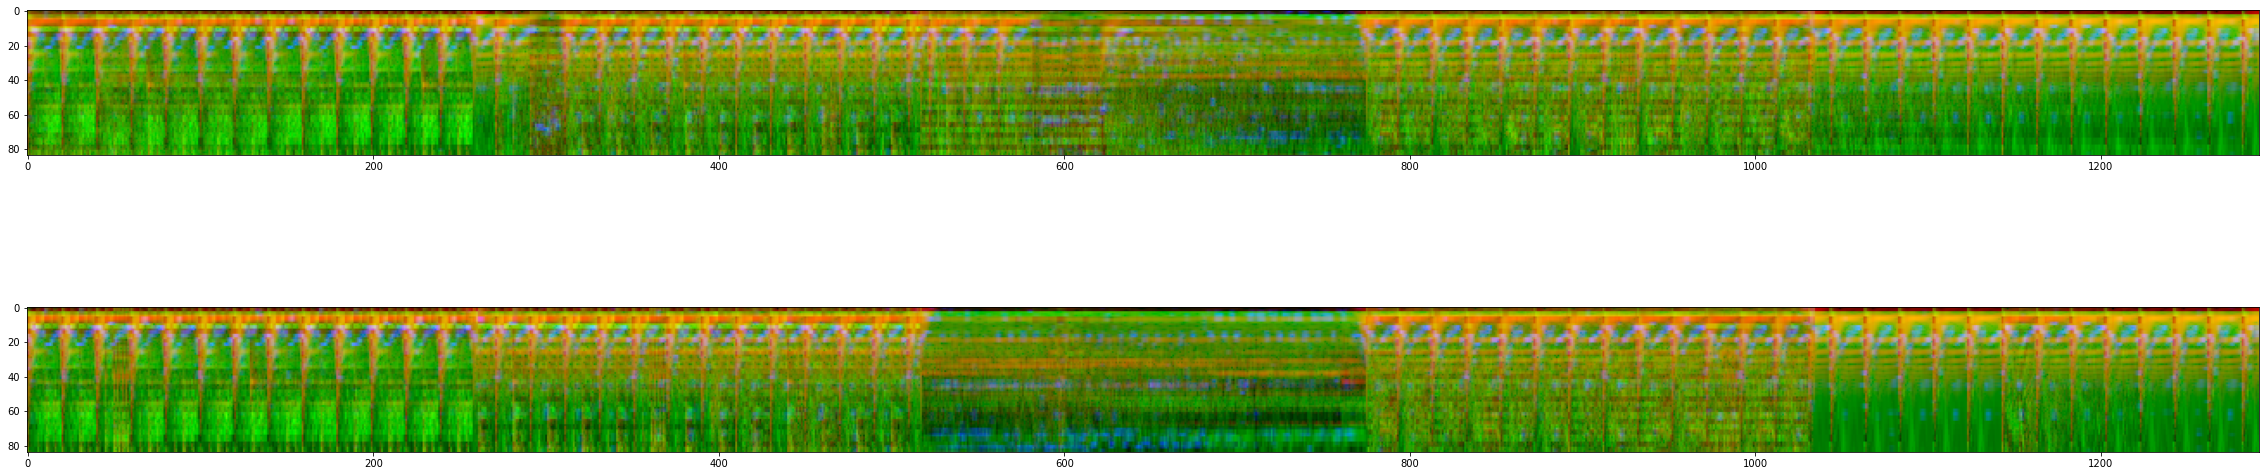

In [14]:
img = song_to_img(
    audio_files[0,0], 
    hop_length=1024,
    num_sample = 5,
    sample_length=6,
    sample_rate = 44100,
    offset = 0,
    max_offset=1)
img2 = song_to_img(
    audio_files[0,0], 
    hop_length=1024,
    num_sample = 5,
    sample_length=6,
    sample_rate = 44100,
    offset = 1,
    max_offset=1)
plt.figure(figsize=(40,10))
plt.subplot(2,1,1)
plt.imshow(img)
plt.subplot(2,1,2)
plt.imshow(img2)

### EXEMPLE D'UNE CREATION DE FEATURES

In [12]:
SONG_NUM = 0
img = song_to_img(
    audio_files[SONG_NUM,0], 
    hop_length=1024,
    num_sample = 5,
    sample_length=6,
    sample_rate = 44100,
    offset = 0,
    max_offset=0)
print(img.shape)
r = img[:,:,0]
g = img[:,:,1]
b = img[:,:,2]

(84, 1292, 3)


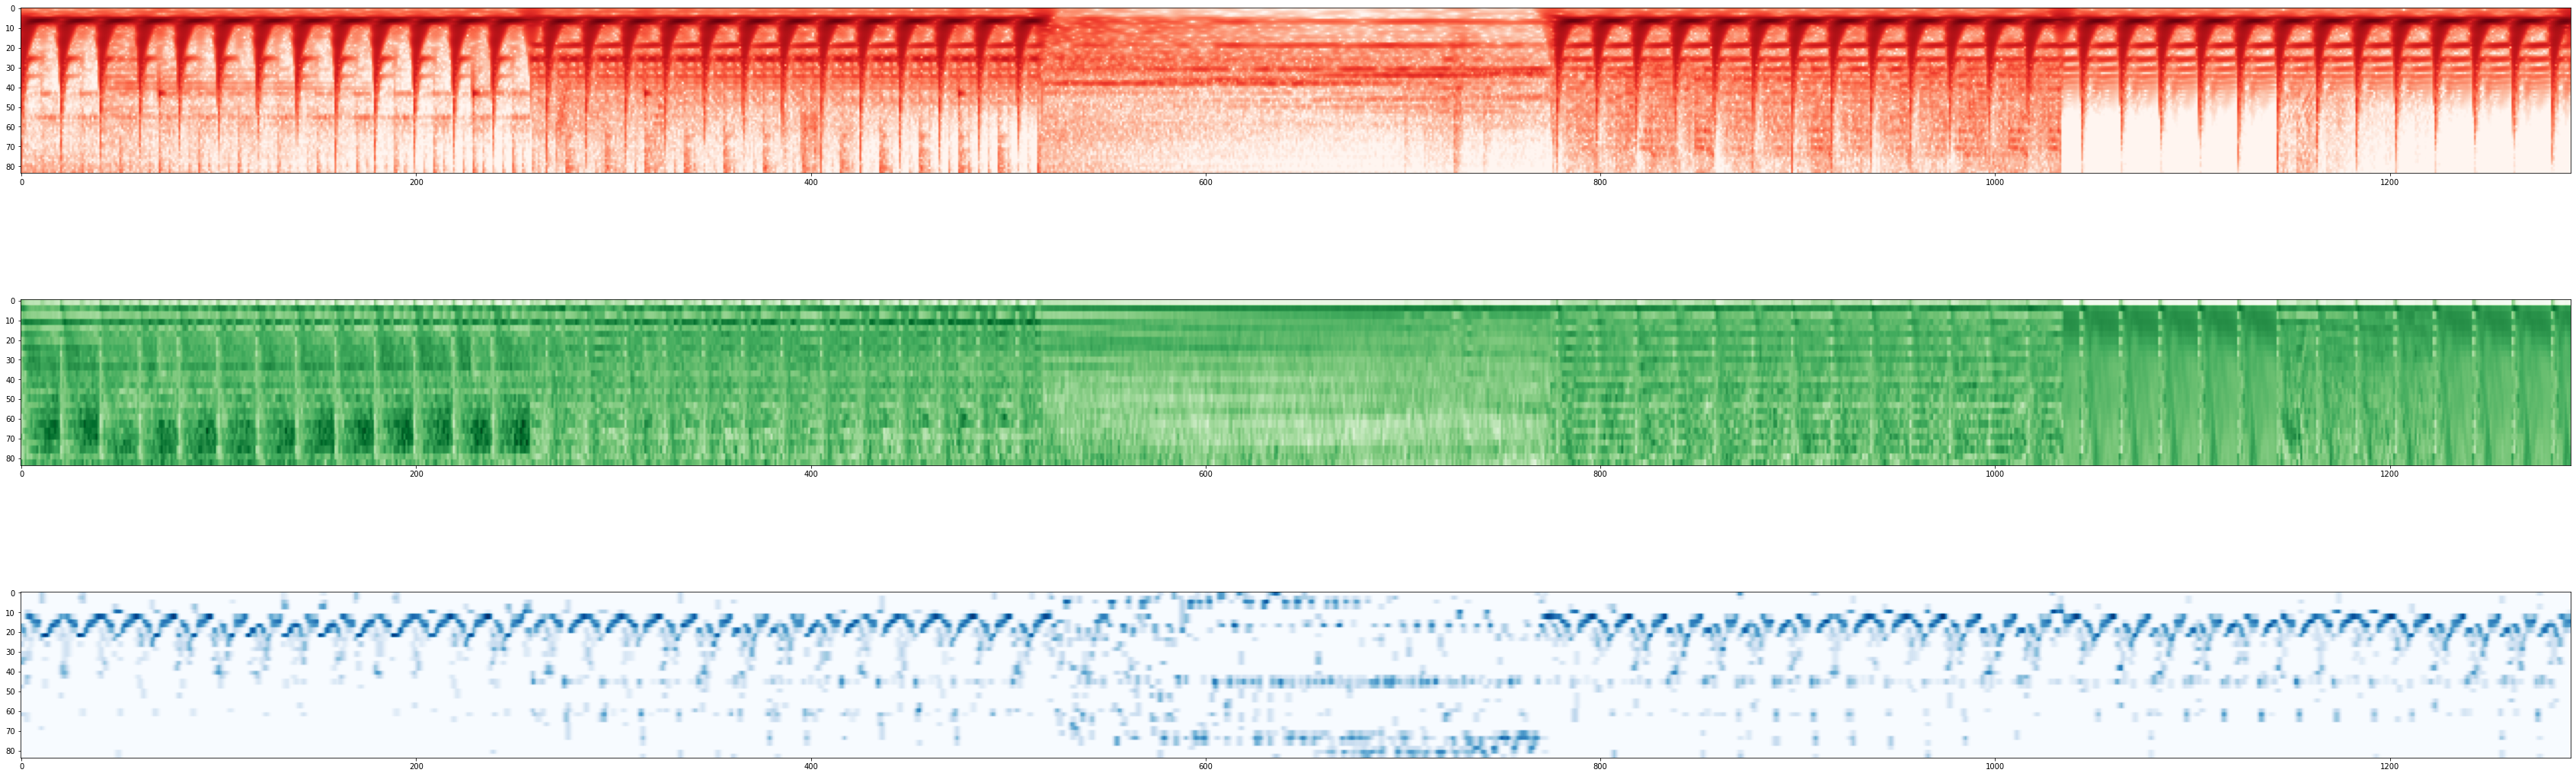

In [13]:
plt.figure(figsize=(60,20))
plt.subplot(3,1,1)
plt.imshow((r), cmap="Reds")
plt.subplot(3,1,2)
plt.imshow(g, cmap="Greens")
plt.subplot(3,1,3)
plt.imshow(b, cmap="Blues")
plt.show()

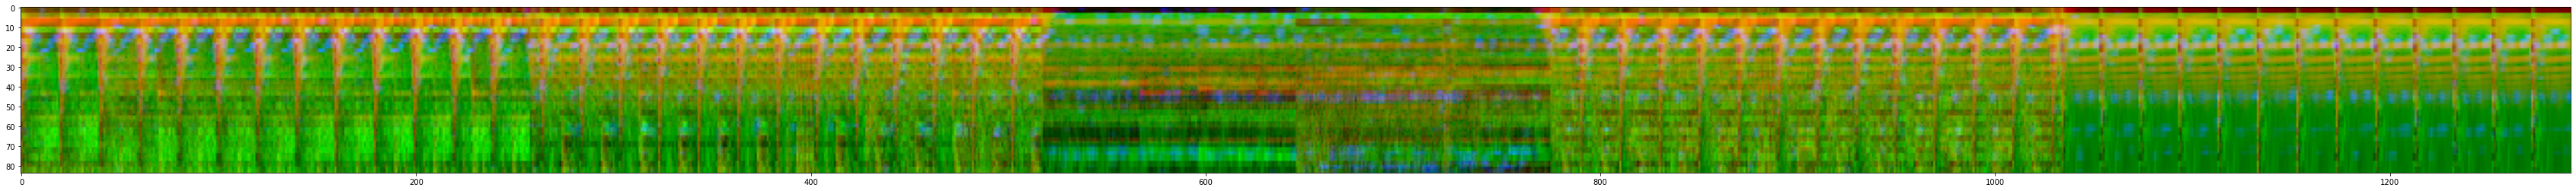

In [9]:
rgb = np.dstack((r,g,b))
plt.figure(figsize=(60,8))
plt.imshow(rgb)

### CREATION DES FEATURES POUR LA LISTE DES MUSIQUES

In [15]:
audio_files = get_audio_list(max_samples=250)
HOW_MANY = len(audio_files)
MAX_OFFSET = np.max(audio_files[:, 2].astype(int))
X = np.array(p_map(
    song_to_img,
    audio_files[:, 0],
    [1024]*HOW_MANY,
    [5]*HOW_MANY,
    [6]*HOW_MANY,
    [44100]*HOW_MANY,
    audio_files[:, 2],
    [MAX_OFFSET]*HOW_MANY), dtype=np.uint8)
print(X.shape)

y = audio_files


Folder : /home/george/code/clumzy/electronic_tagger/datasets/audio_files/minimal_techno
Folder : /home/george/code/clumzy/electronic_tagger/datasets/audio_files/breakbeat_techno
Folder : /home/george/code/clumzy/electronic_tagger/datasets/audio_files/soulful_house
Folder : /home/george/code/clumzy/electronic_tagger/datasets/audio_files/acid_house
Folder : /home/george/code/clumzy/electronic_tagger/datasets/audio_files/progressive_house
Folder : /home/george/code/clumzy/electronic_tagger/datasets/audio_files/hard_trance
Folder : /home/george/code/clumzy/electronic_tagger/datasets/audio_files/deep_house
Folder : /home/george/code/clumzy/electronic_tagger/datasets/audio_files/melodic_techno
Folder : /home/george/code/clumzy/electronic_tagger/datasets/audio_files/industrial_techno
Folder : /home/george/code/clumzy/electronic_tagger/datasets/audio_files/detroit_house
Folder : /home/george/code/clumzy/electronic_tagger/datasets/audio_files/breakbeat_house
Folder : /home/george/code/clumzy/el

100%|██████████| 5250/5250 [1:08:12<00:00,  1.28it/s]


(5250, 84, 1292, 3)


### EXPORT DES FEATURES

In [17]:
import pickle
pickle.dump(X, open( os.path.join("/home/george/code/clumzy/electronic_tagger/images","images_big.pkl"), "wb" ) )
pickle.dump(y, open( os.path.join("/home/george/code/clumzy/electronic_tagger/images","target_big.pkl"), "wb" ) )

### AFFICHAGE DES FEATURES

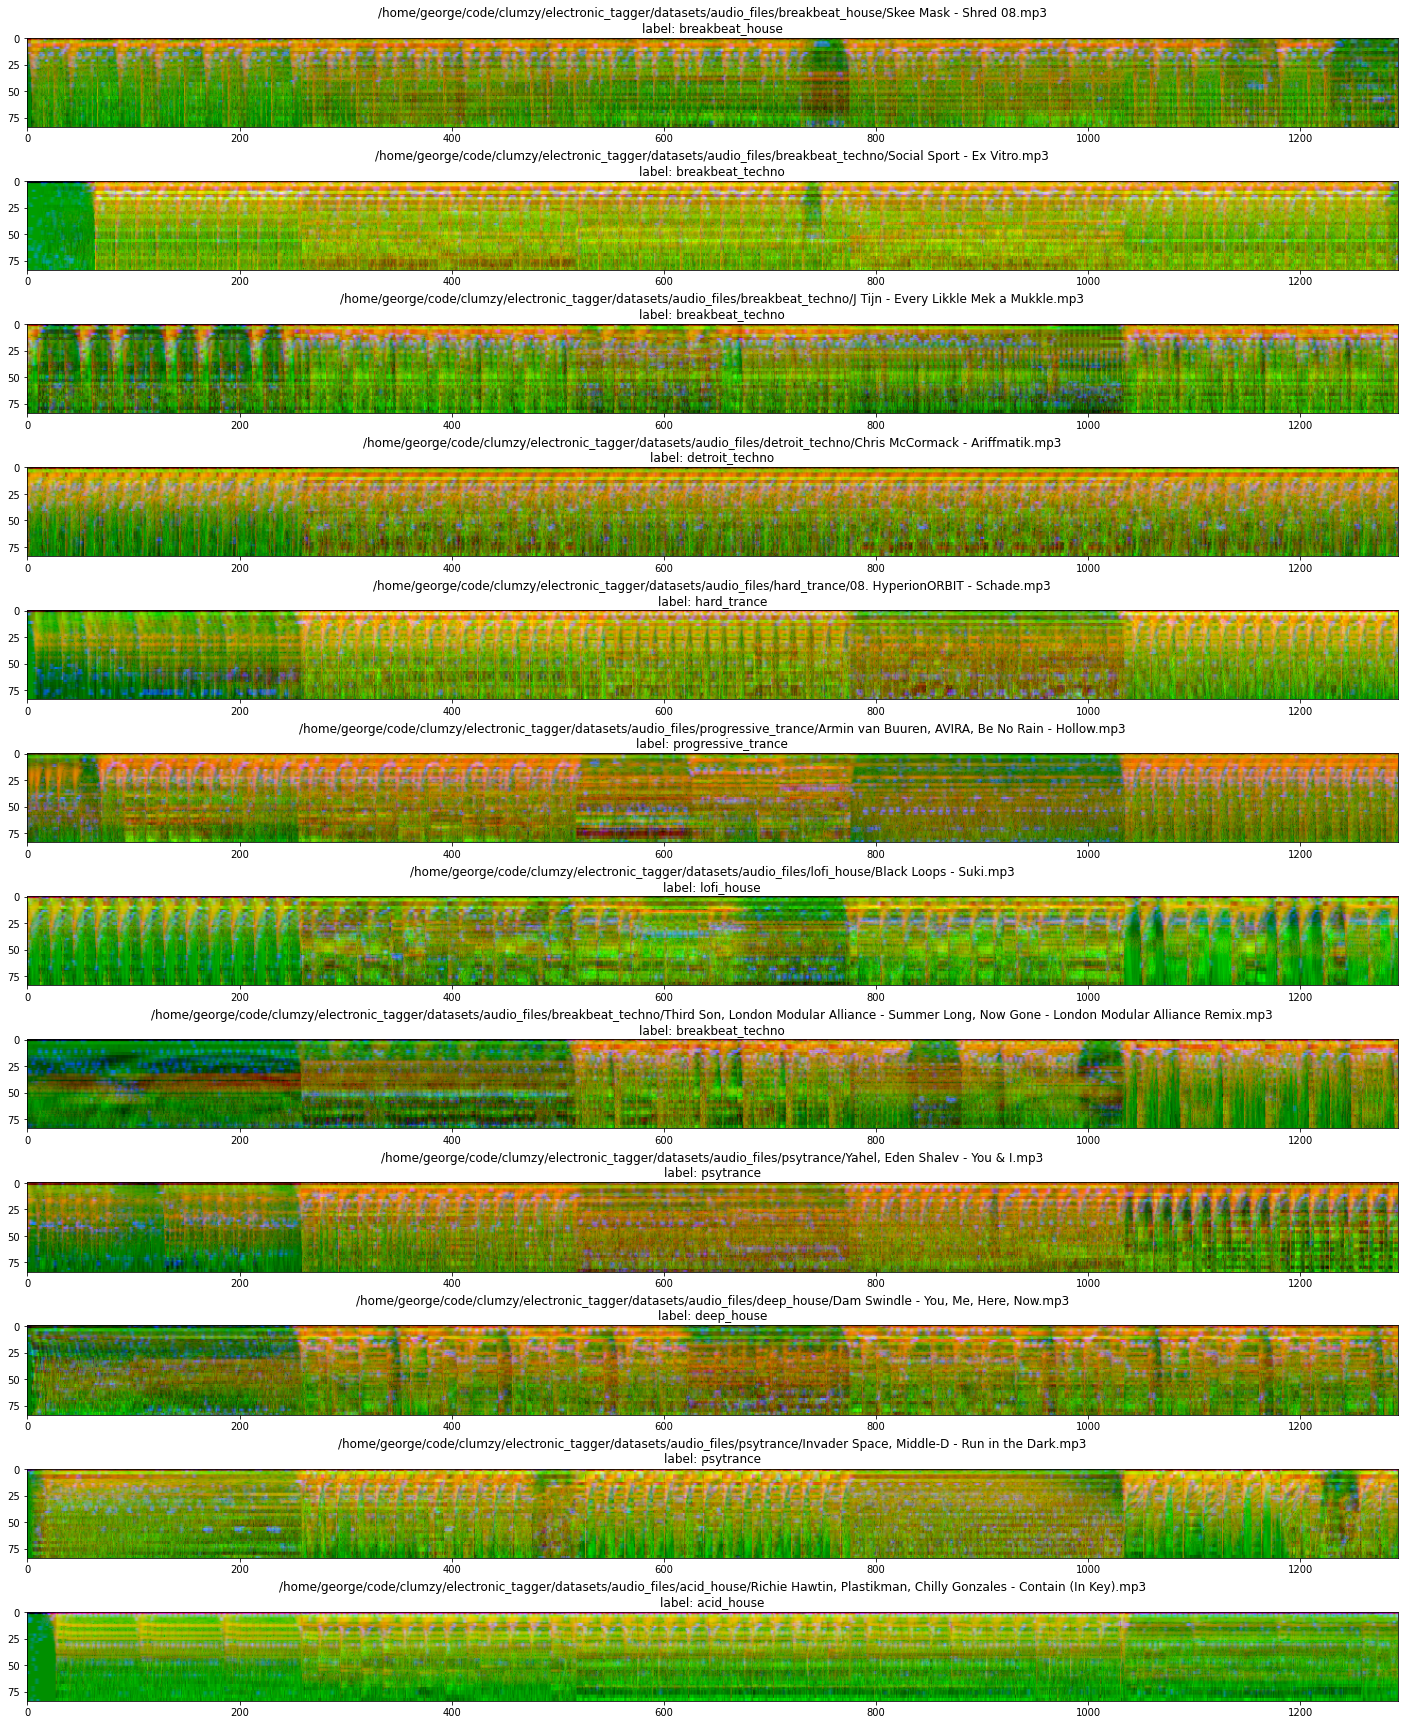

In [25]:
images = np.random.choice(range(X.shape[0]), 12, replace = False) #type: ignore
plt.figure(2, figsize=(24, 24))
for i in range(1, 13):
    plt.subplot(12, 1, i)
    plt.imshow(X[images[i-1]])
    plt.title(f"{y[:,0][images[i-1]]}\nlabel: {y[:,1][images[i-1]]}")
plt.tight_layout()
plt.show()

In [18]:
import pickle
X = pickle.load(open(os.path.join("/home/george/code/clumzy/electronic_tagger/images/images_big.pkl"), "rb"))


(5250, 84, 1292, 3)

In [23]:
X1 = X[:2625]
X2 = X[2625:]
pickle.dump(X1, open( os.path.join("/home/george/code/clumzy/electronic_tagger/images","images_big_part1.pkl"), "wb" ) )
pickle.dump(X2, open( os.path.join("/home/george/code/clumzy/electronic_tagger/images","target_big_part2.pkl"), "wb" ) )